In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Last date entry in the datatable
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last data point in the database
# Since there are 365 days a year, so we are including the first day of the year
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')

# Setting index to date
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date',ascending=True)
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


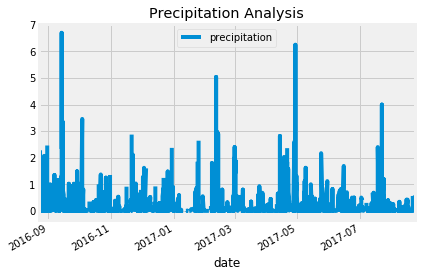

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df .plot(title="Precipitation Analysis")
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation_Analysis.png")
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"[({available_stations})] ")

[(9)] 


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,                     
                                    func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Finding the most active station 
most_active_station=active_stations[0][0]
print(f"{most_active_station}")

USC00519281


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps_records = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f"{temps_records[0][0]}, {temps_records[0][1]}, {round(temps_records[0][2], 1)}")

54.0, 85.0, 71.7


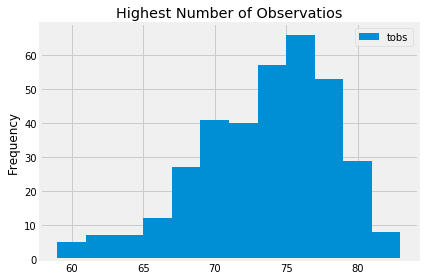

In [19]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['tobs'])

# Plotting with Matplotlib to plot the data as a histogram
temperature_observations.plot.hist(bins=12, title="Highest Number of Observatios")
plt.tight_layout()
plt.savefig("Images/Observation_Histogram.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = calc_temps('2017-02-28','2017-03-05')
trip

[(64.0, 72.02777777777777, 78.0)]

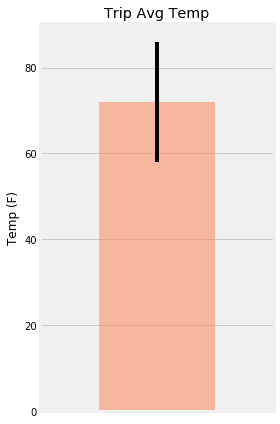

In [22]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-02-28','2017-03-05'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.58), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.16), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.04), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.04), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
start_date = dt.datetime.strptime('2017-02-28', "%Y-%m-%d")
end_date = dt.datetime.strptime('2017-03-05', "%Y-%m-%d")
#st_str_dt = start_date.strftime("%m-%d")
normals = []
dt_list = []

iter_date = start_date
while iter_date <= end_date:
    dt_list.append(iter_date)
    st_str_dt = iter_date.strftime("%m-%d")
    #print(st_str_dt)
    iter_date += dt.timedelta(1)
    normals.append(*daily_normals(st_str_dt))

print("Aggregate Daily Normals for 02-28 to 03-05")
normals

Aggregate Daily Normals for 02-28 to 03-05


[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df2 = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df2['Date'] = pd.to_datetime(dt_list)
df2.set_index('Date', inplace=True)
df2

,tmin,tavg,tmax
Date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


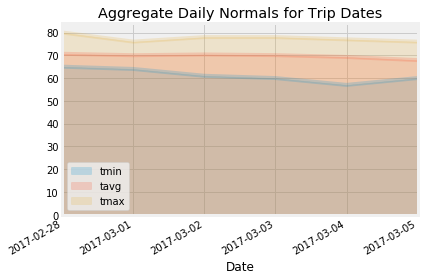

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
df2.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()